# Threshold Tests

This Jupyter notebook is used to test different thresholding methods on overhead images.

Make sure to run the imports cell first. Other cells are optional, especially commented out ones.

In [1]:
""" Imports. Always run first. """

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline 

In [2]:
""" Overhead image generator. 
Use to convert dashboard images to overhead images and save results to file.
Be careful to not write over existing files!
"""
# from find_lane import DashboardCamera
# from scipy.misc import imsave

# # Files to transform to overhead view
# img_files = glob.glob('./test_images/*.jpg')

# # Get calibration
# calibration_img_files = glob.glob('./camera_cal/*.jpg')
# lane_shape = [(584, 458), (701, 458), (295, 665), (1022, 665)]
# camera = DashboardCamera(calibration_img_files, chessboard_size=(9, 6), lane_shape=lane_shape)

# # Save images
# imgs = [camera.warp_to_overhead(camera.undistort(plt.imread(f))) for f in img_files]
# for i, img in enumerate(imgs):
#     imsave('./threshold_test_imgs/road_{}.jpg'.format(i), img)

' Overhead image generator. \nUse to convert dashboard images to overhead images and save results to file.\nBe careful to not write over existing files!\n'

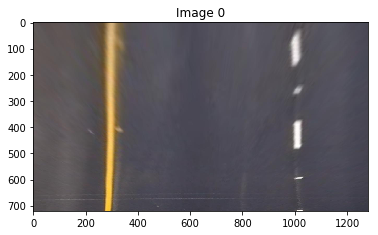

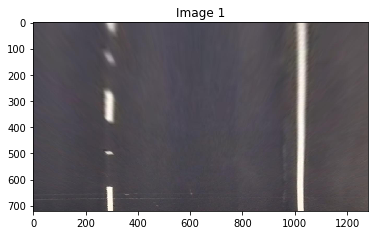

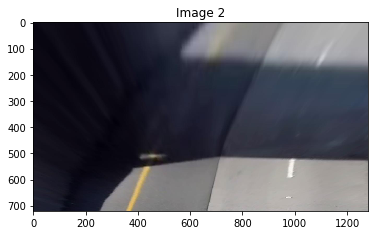

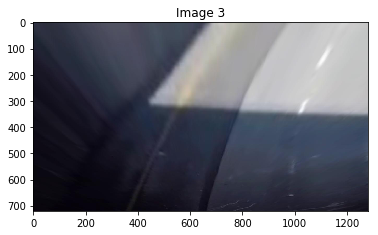

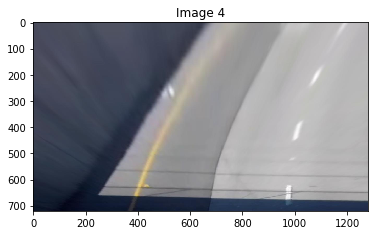

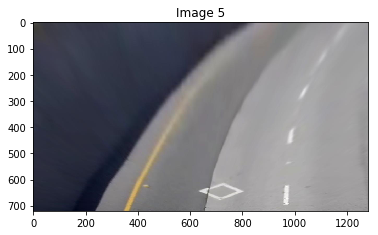

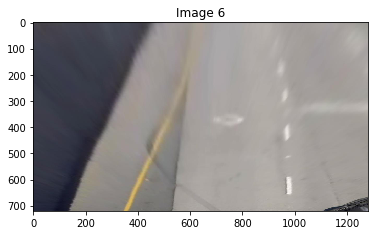

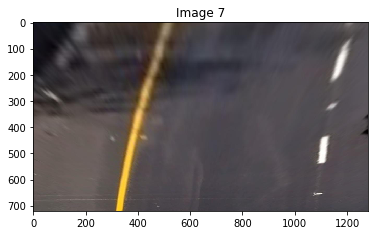

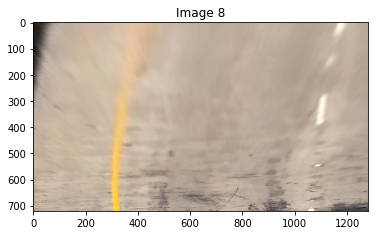

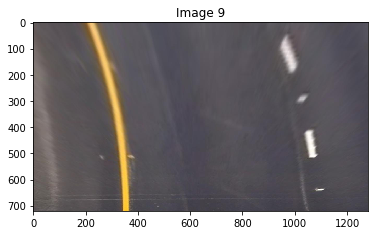

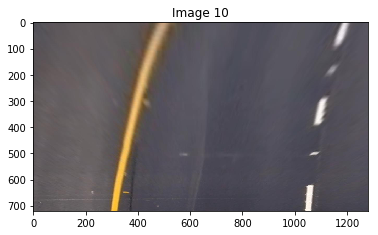

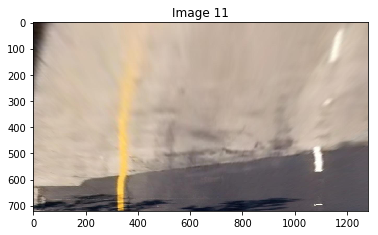

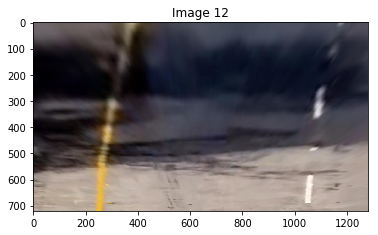

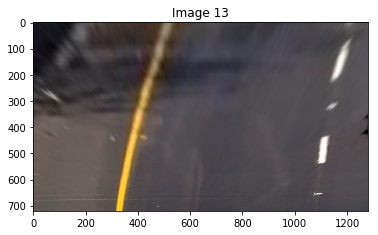

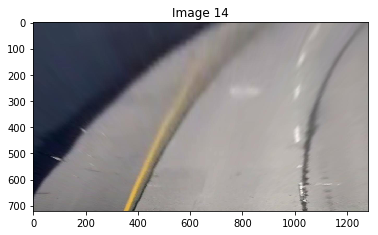

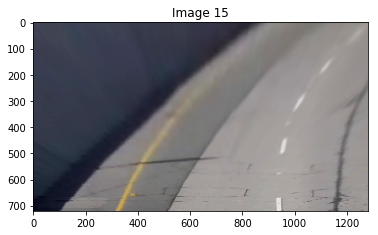

In [3]:
""" Load images. """

img_files = glob.glob('./threshold_test_imgs/*.jpg')
imgs = [plt.imread(f) for f in img_files]

for i, img in enumerate(imgs):
    plt.figure()
    plt.imshow(img)
    plt.title('Image {}'.format(i))

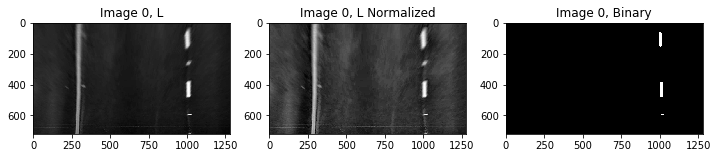

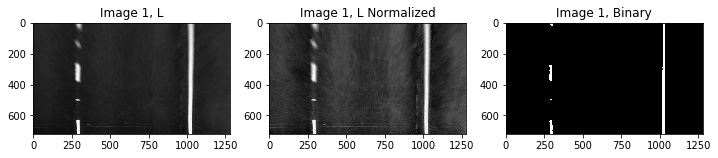

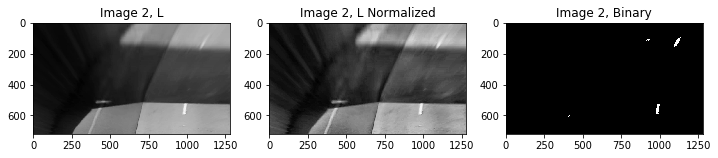

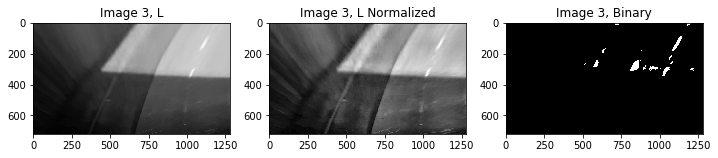

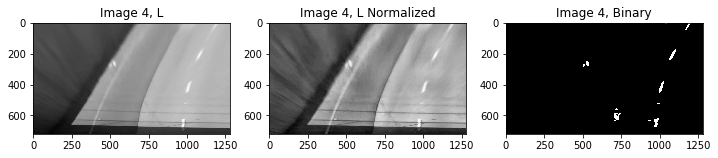

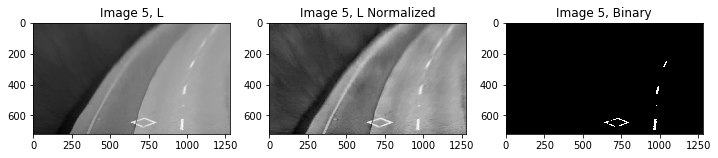

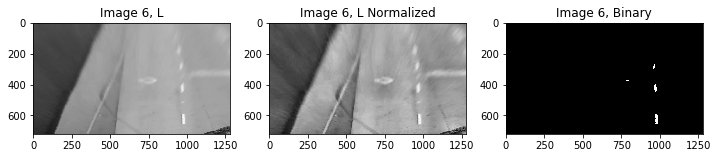

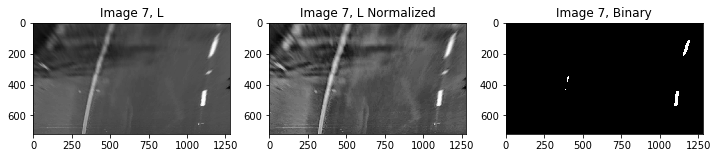

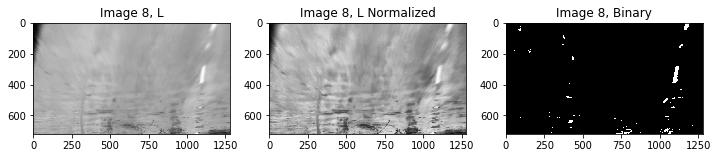

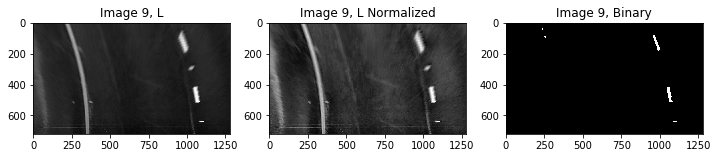

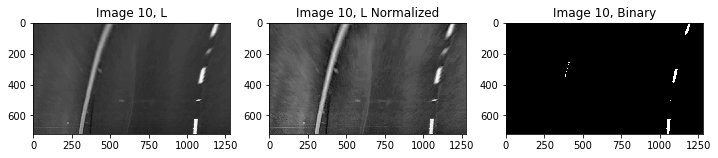

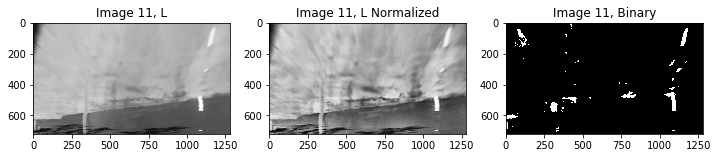

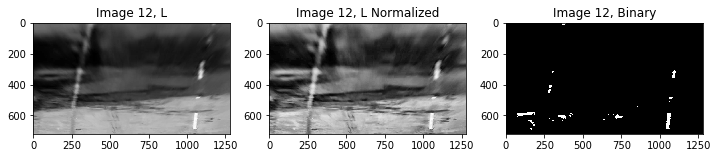

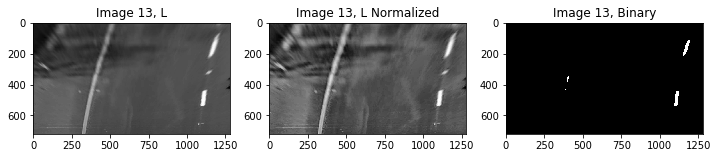

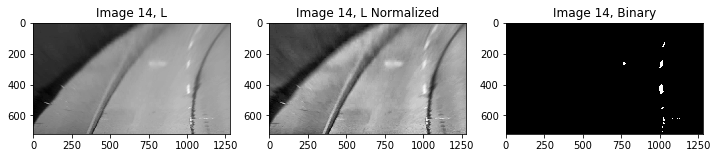

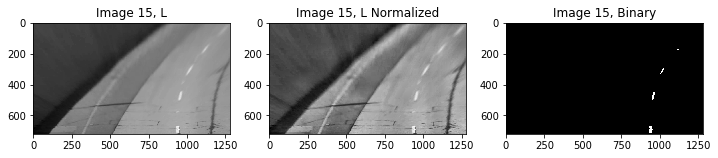

In [4]:
""" Single channel threshold pipeline. """

def adaptive_threshold(gray, clipLimit, threshold, blockSize):
    # NOTE: cv2.adaptiveThreshold() tends to be slow!
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=(8,8))
    norm_img = clahe.apply(gray)
    
    binary = cv2.adaptiveThreshold(
        norm_img,
        maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=blockSize,
        C=threshold * -1)
    return binary, norm_img

def basic_threshold(gray, clipLimit, threshold):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=(8,8))
    norm_img = clahe.apply(gray)
    ret, binary = cv2.threshold(norm_img, threshold, 255, cv2.THRESH_BINARY)
    return binary, norm_img
    

# Parameters
cspace = 'HLS'
channel = 1
clipLimit = 2.0
threshold = 210

# Execute
color_t = getattr(cv2, 'COLOR_RGB2{}'.format(cspace))
for i, img in enumerate(imgs):
    gray = cv2.cvtColor(img, color_t)[:,:,channel]
    binary, norm_img = basic_threshold(gray, clipLimit, threshold)
    
    matplotlib.rcParams['figure.figsize'] = (12,12)
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Image {}, {}'.format(i, cspace[channel]))
    plt.subplot(1, 3, 2)
    plt.imshow(norm_img, cmap='gray')
    plt.title('Image {}, {} Normalized'.format(i, cspace[channel]))
    plt.subplot(1, 3, 3)
    plt.imshow(binary, cmap='gray')
    plt.title('Image {}, Binary'.format(i))
    matplotlib.rcParams['figure.figsize'] = (6,6)

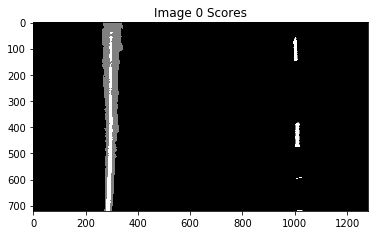

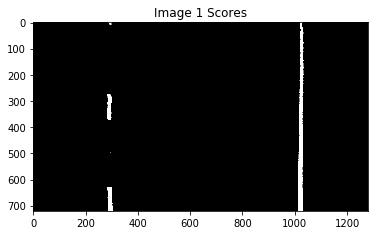

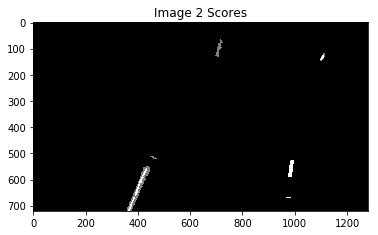

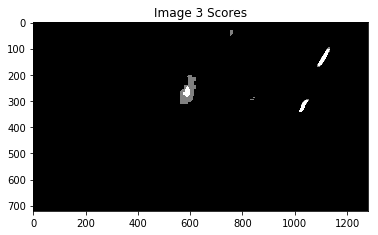

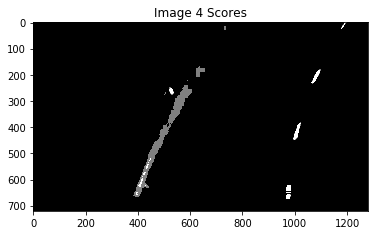

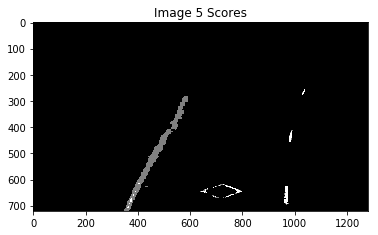

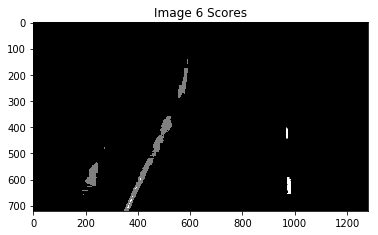

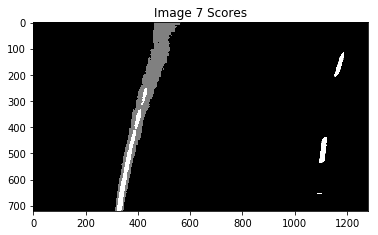

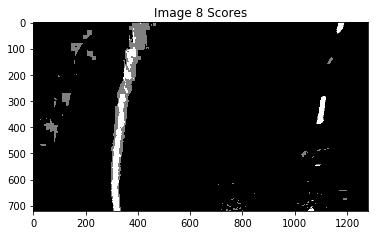

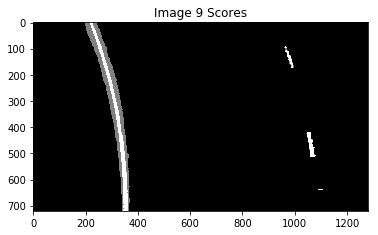

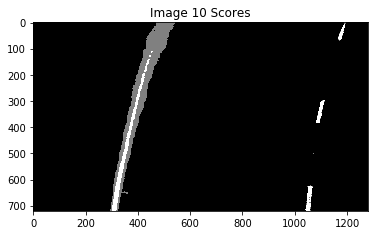

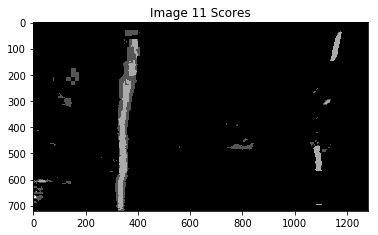

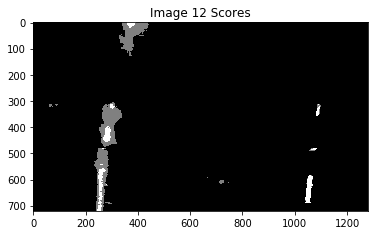

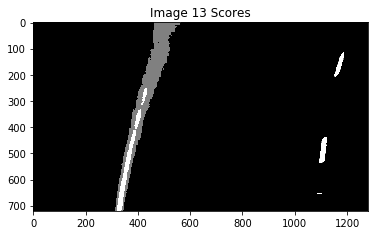

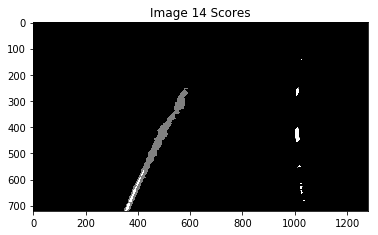

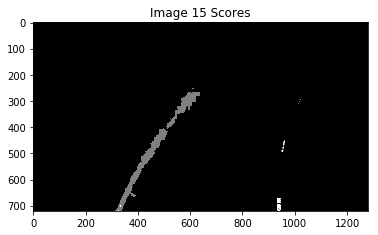

In [20]:
# Parameters
settings = []
settings.append({'cspace': 'LAB', 'channel': 2, 'clipLimit': 2.0, 'threshold': 150})
settings.append({'cspace': 'HLS', 'channel': 1, 'clipLimit': 1.0, 'threshold': 220})
settings.append({'cspace': 'HSV', 'channel': 2, 'clipLimit': 3.0, 'threshold': 230})


# Execute
for i, img in enumerate(imgs):
    scores = np.zeros(imgs[0].shape[0:2])
    for s in settings:
        color_t = getattr(cv2, 'COLOR_RGB2{}'.format(s['cspace']))
        gray = cv2.cvtColor(img, color_t)[:,:,s['channel']]
        binary, norm_img = basic_threshold(gray, s['clipLimit'], s['threshold'])
        scores += binary

    plt.figure()
    plt.imshow(scores, cmap='gray')
    plt.title('Image {} Scores'.format(i))

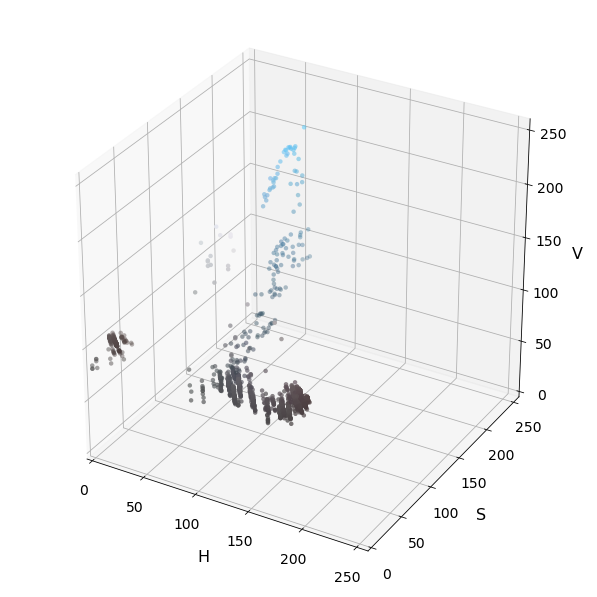

In [6]:
""" Color space viewer.
Modify  this to view the color space of each image and understand how it could be
separated.

Code modified from Udacity.
"""
from mpl_toolkits.mplot3d import Axes3D


def plot3d_color(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Read a color image
img = imgs[0]

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d_color(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()